# Exemple emcee

Dans ce notebook, nous utiliserons _emcee_ pour échantillonner la distribution a posteriori d'un modèle périodique à 5 paramètres.

## Génération de fausses données

Nous allons d'abord générer des données pour les utiliser dans l'exemple.
Les données seront générées avec une fonction sinus. On ajoute ensuite un bruit gaussien aux valeurs. On ajoute un terme de bruit additionnel qui n'est pas inclut dans les barres d'erreurs. Le but est d'explorer une situation où les barres d'erreurs sont sous-estimées.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)  # Pour toujours avoir les mêmes valeurs random

# Définition des vrais paramètres
amp_true = 1.6
per_true = 0.7
phi_true = 1.1
off_true = 0.2
sigma_true = 0.2
truths =  [
    np.log(amp_true),
    per_true,
    phi_true,
    off_true,
    np.log(sigma_true),
]

npts = 50
t = np.sort(2 * per_true * np.random.rand(npts))
y_true = amp_true * np.sin(2*np.pi * t / per_true + phi_true) + off_true
yerr = amp_true * 0.01 + 0.15 * amp_true * np.random.rand(npts)
y = y_true + yerr * np.random.randn(npts) + sigma_true * np.random.randn(npts)

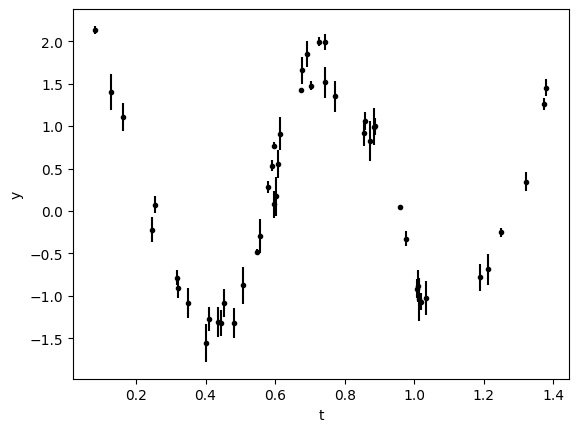

In [2]:
plt.errorbar(t, y, yerr=yerr, fmt="k.", label="Données")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

## Définition du problème

Une fois que les données sont connues, il est temps de formuler le problème pour l'analyse MCMC.

On définit d'abord notre modèle qui permet de générer les valeurs de $y$ pour une série de valeurs $t$ (ou `t` dans le code). Les paramètres sont dénotés par `theta`.

La fonction de vraisemblance est une probablité gaussienne et les priors sont tous uniforme.
Remarquez le paramètre $s$. Il s'agit d'un bruit gaussien ajouté en quadrature aux barres d'erreur dans la vraisemblance. Si les barres d'erreurs sont sous-estimées par rapport au bruit présent dans les données, ce paramètre devrait être non nul.
Pour tenir compte de ce paramètre, il suffit de l'ajouter (en quadrature) aux barres d'erreur dans le calcul de la vraisemblance. Ce paramètre ne doit pas être "passé" au modèle `model`.

Afin d'avoir un _prior_ log-uniforme sur l'amplitude et le bruit additionnel, on utilise le log des paramètres avec un _prior_ uniforme. C'est une alternative valable à l'utilisation d'un prior log-uniforme sur le paramètre directement.

La distribution « posterior » n'est qu'une multiplication du prior par la vraisemblance: l'évidence n'est pas utilisée avec `emcee`.
Le prior est généralement moins couteux en temps de calcul. C'est pourquoi on calcule d'abord le prior, puis on calcule la vraisemblance uniquement si le prior est non nul.

Remarquez que toutes les distributions sont sous forme logarithmique. Ceci aide à la stabilité numérique et l'exploration efficace de l'espace-paramètres.

**Exercice: implémentez les fonctions pour le modèle, le log-likelihood, le log-prior et log-posterior.** Pour le prior, je suggère d'implémenter une fonction de prior uniforme (en log) et de la réutiliser pour tous les paramètres.

In [3]:
def model(t, theta):
    log_amp, per, phi, off = theta
    amp = np.exp(log_amp)
    ymod = amp * np.sin(2 * np.pi * t / per + phi) + off
    return ymod


def log_likelihood(theta, t, y, yerr):
    theta_model = theta[:-1]
    log_s = theta[-1]
    modvals = model(t, theta_model)

    sigma2 = yerr ** 2 + np.exp(2 * log_s)
    norm_const = -0.5 * np.sum(np.log(2 * np.pi * sigma2))
    chisq = np.sum((y - modvals) ** 2 / sigma2)

    return -0.5 * chisq + norm_const


def uniform_prior(pval, minval, maxval):
    if minval <= pval <= maxval:
        return - np.log(maxval - minval)
    return - np.inf


def log_prior(theta):
    log_amp, per, phi, off, log_s = theta
    prior = 0.0
    prior += uniform_prior(log_amp, -5.0, 5.0)
    prior += uniform_prior(per, 0.0, 10.0)
    prior += uniform_prior(phi, -np.pi, np.pi)
    prior += uniform_prior(off, -10.0, 10.0)
    prior += uniform_prior(log_s, -5.0, 5.0)
    return prior


def log_posterior(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

## Test du modèle

On peut maintenant tester le modèle pour explorer à l'oeil quelques valeurs de paramètres et s'assurer que le modèle correspond environ aux données.

**Exercice: Testez différentes valeurs de paramètres (`pguess`) et évaluez le modèle. Choisissez ainsi une valeur de départ plausible pour le MCMC.**

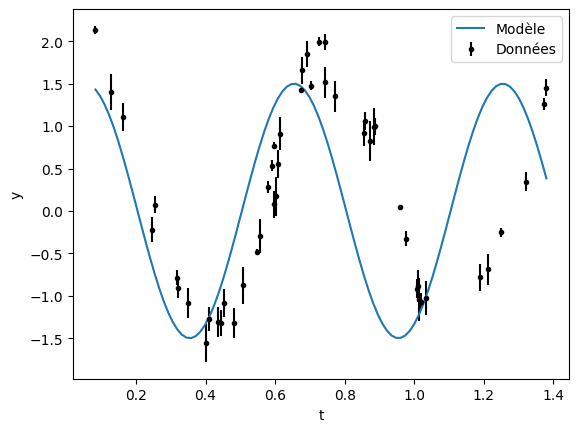

In [4]:
pguess = np.array([np.log(1.5), 0.6, 1.0, 0.0, -1.0])
tmod = np.linspace(t.min(), t.max(), num=100)
plt.errorbar(t, y, yerr=yerr, fmt="k.", label="Données")
plt.plot(tmod, model(tmod, pguess[:-1]), label="Modèle")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()

## MCMC avec emcee

Il est maintenant temps d'estimer les valeurs de chaque paramètre avec `emcee`. 

**Exercice: implémentez un MCMC avec les paramètres suivants:**

- 100 walkers (chaînes)
- 5000 pas
- Positions de départ dans une petite "balle" gaussienne autour de la position de départ `pguess` trouvée plus haut

In [5]:
import emcee

In [6]:
nwalkers = 100
ndims = pguess.size
sampler = emcee.EnsembleSampler(nwalkers, ndims, log_posterior, args=(t, y, yerr))

In [7]:
nsteps = 5000
pos = pguess + 1e-4 * np.random.randn(nwalkers, ndims)
sampler.run_mcmc(pos, nsteps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 333.80it/s]


Un premier diagnostic souvent utile consiste à regarder l'évolution des chaines (tous les « walkers » sont affichés pour chaque paramètre). Ce graphique permet généralement d'identifier le « burn-in » requis.

**Exercice affichez les chaînes pour tous les paramètres et déterminez un temps de "burn-in" raisonnable. Définissez une variable `nburn` qui vous permettra de rejeter les premiers échantillons pour le reste du Notebook.**

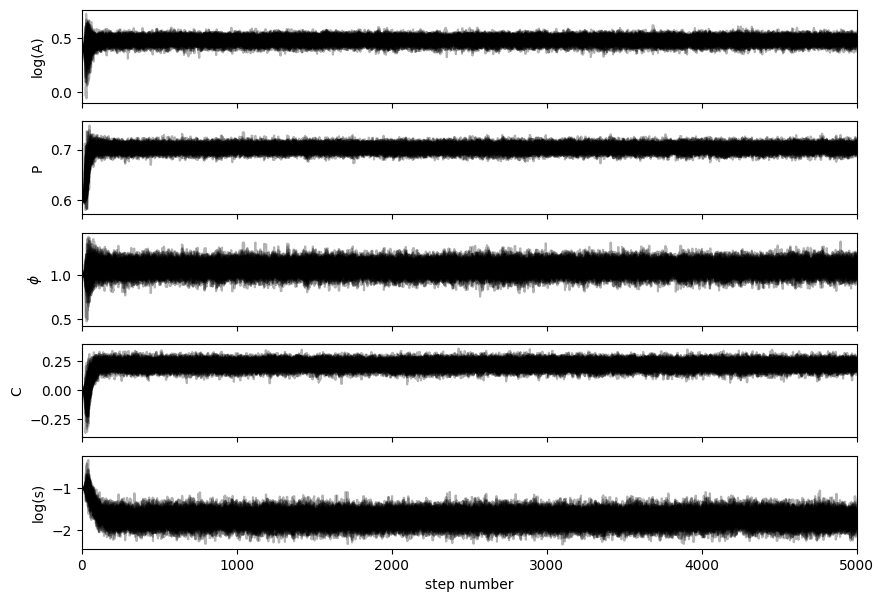

In [8]:
fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=0)
labels = ["log(A)", "P", r"$\phi$", "C", "log(s)"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step number")
plt.show()

In [9]:
nburn = 500

Afin d'évaluer la convergence, on peut calculer le temps d'autocorrélation et s'assurer qu'il est inférieur à $N_{\text{step}}/50$.

**Exercice: calculez le temps d'autocorrélation. N'oubliez pas de rejeter le _burn-in_**

In [10]:
sampler.get_autocorr_time(discard=nburn)

array([48.20354894, 53.15516314, 52.86206977, 49.59338776, 49.25383215])

Un autre type de graphique utile est le « corner plot ». Ce graphique affiche un histogramme pour chaque paramètre (distribution marginalisée), ainsi que la distribution 2D pour chaque paire de paramètre. On peut ainsi voir les (anti-)corrélations entre certains paramètres.

**Affichez le corner plot pour tous les paramètres, affichez les titres, le nom des paramètres, et les quantiles 0.16, 0.5 et 0.84. Explorez les options présente dans `corner`.**

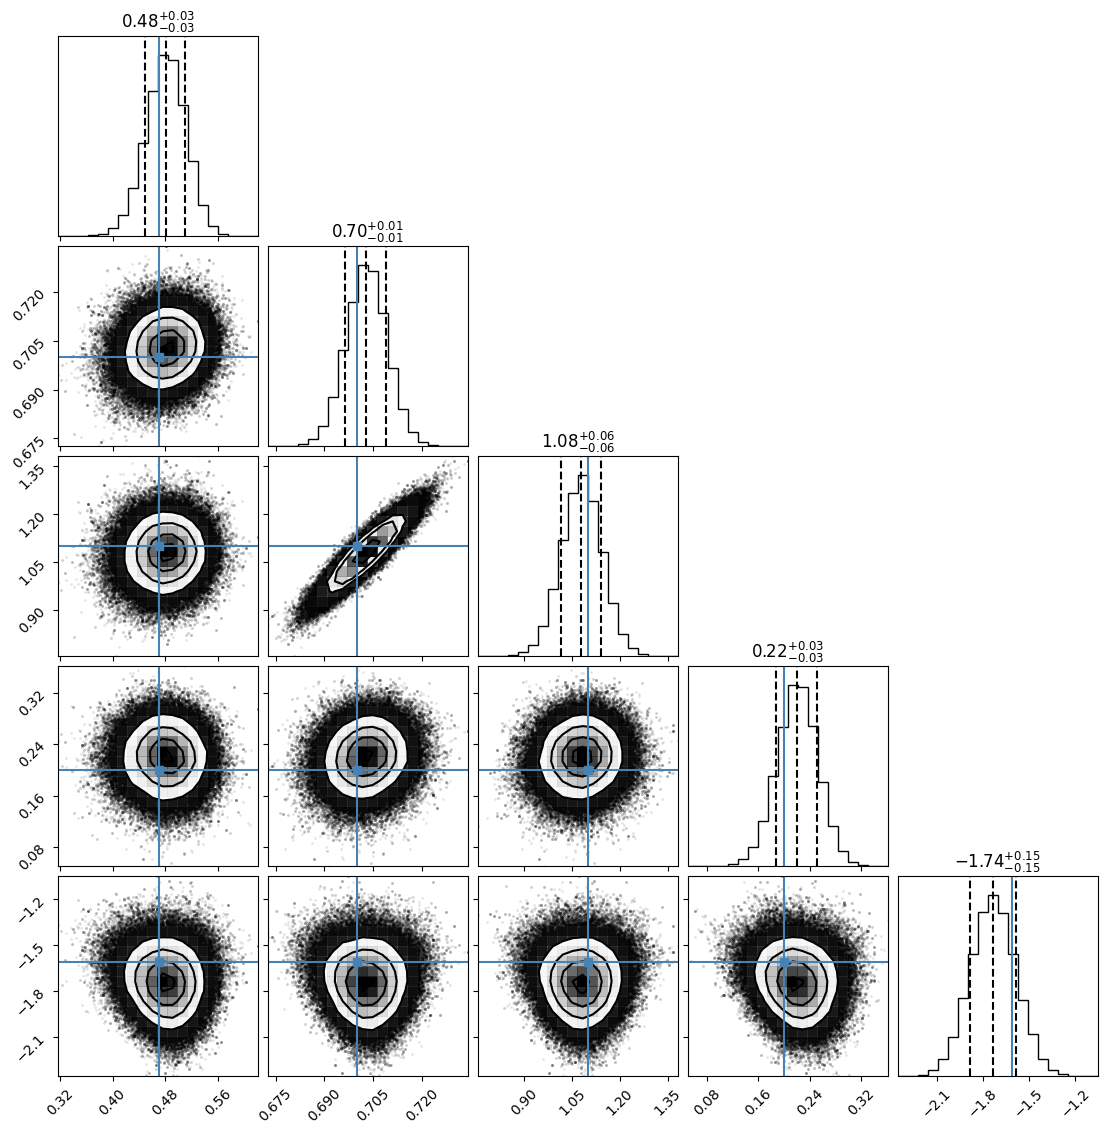

In [11]:
import corner

flat_samples = sampler.get_chain(discard=nburn, flat=True)

corner.corner(flat_samples, show_titles=True, truths=truths, quantiles=[0.16, 0.5, 0.84])
plt.show()

**Exercice: Affichez 100 échantillons pour le modèle, superposés aux données**

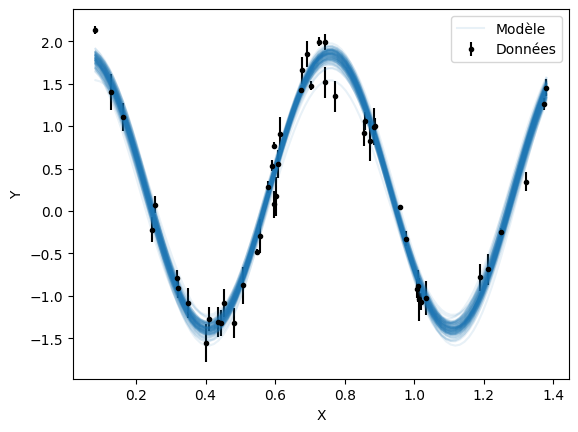

In [12]:
tmod = np.linspace(t.min(), t.max(), num=100)
plt.errorbar(t, y, yerr=yerr, fmt="k.", label="Données")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(tmod, model(tmod, sample[:-1]), "C0", alpha=0.1, label="Modèle" if ind == inds[0] else None)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()